### **TP1**

#### *Author*: Naïl Khelifa

Practical 1: The goal of this practical session is to build backprop from scratch and a small neural network (MLP).

Please return your notebook right at the end of the session.  You then have a week to return an updated version.

In [30]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
import graphviz

graphviz.set_jupyter_format('svg')
graph = graphviz.Source('digraph G { A -> B }', engine='dot')

# Save the output instead of opening it
graph.render(filename='output_graph', format='png', cleanup=False)

print("Graph saved as 'output_graph.png'. Open it manually.")

Graph saved as 'output_graph.png'. Open it manually.


In [32]:
from graphviz import Digraph

In [33]:
# code to display a network - do not modify this cell
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    layer_colors = ["#FFCCCC", "#CCFFCC", "#CCCCFF", "#FFCC99", "#99CCFF"]
    
    def get_color(node):
        if node._op == '+': return layer_colors[0]
        elif node._op == '*': return layer_colors[1]
        elif node._op == 'tanh': return layer_colors[2]
        # Ajoutez d'autres conditions ici pour d'autres opérations ou couches
        return layer_colors[-1]  # Couleur par défaut
    
    for n in nodes:
        color = get_color(n)
        dot.node(name=str(id(n)), label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record', style='filled', fillcolor=color)
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [34]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other): # TODO: ex.1 
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+') ##
    def _backward():
      self.grad += out.grad
      other.grad += out.grad
    out._backward = _backward
    return out

  def __mul__(self, other): # TODO: ex.1 
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*') ##
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out
  
  def __pow__(self, other): # ex. 6
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data ** (other), (self,), '**')
    def _backward():
      self.grad += (other * self.data ** (other - 1)) * out.grad
    out._backward = _backward
    return out
  
  def exp(self):
    out = Value(math.exp(self.data), (self,), 'exp')
    def _backward():
        self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def __tanh__(self):
    exp_2x = (self * 2).__exp__()
    out = (exp_2x - 1) / (exp_2x + 1)
    def _backward():
      self.grad += (1 - out.data ** 2) * out.grad

    out._backward = _backward
    return out

  
  def __rmul__(self, other): # other * self
    return self * other 

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
      t = (math.exp(2*self.data) - 1)/(math.exp(2*self.data) + 1)
      out = Value(t, (self, ), "tanh")
      def _backward():
        self.grad += (1.0 - t**2) * out.grad
      out._backward = _backward
      return out
  
  def relu(self): # pour la dernière qst
      out = Value(max(self.data, 0), (self,), "relu")

      def _backward():
          self.grad += (out.data > 0) * out.grad  # (out >0) est un booléen donc vaux 0 ou 1
      out._backward = _backward
      return out
  def leaky_relu(self, alpha=0.01):
    out = Value(self.data if self.data > 0 else alpha * self.data, (self,), "leaky_relu")

    def _backward():
      self.grad += (1 if self.data > 0 else alpha) * out.grad  # Pente 1 pour x > 0, alpha sinon

    out._backward = _backward
    return out
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()
  def zerograd(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 0
    for node in reversed(topo):
      node.grad=0    

##### **Exercise 1**: fill in `__add__` and `__mul__` in the Value class to enable the following function. You should get -8.0 as a result.

In [35]:
def lol():

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    return L

print(lol().data)

-8.0


In [36]:
lol()

Value(data=-8.0)

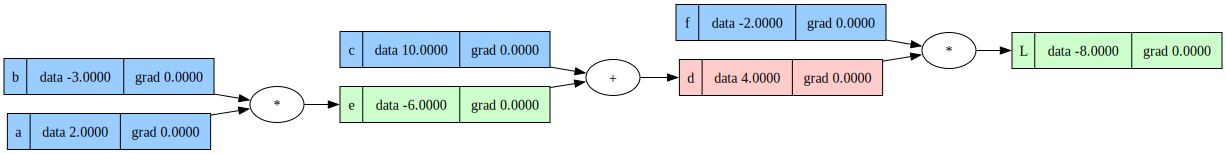

In [37]:
draw_dot(lol())

##### **Exercise 2**: use the `lol_grad()` function below to manually compute dL/df, dL/dd, dL/de, dL/dc, dL/da, dL/db

In [38]:
def lol_grad():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    d += h
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    L2 = L.data


    print("dl/dd = ",(L2-L1)/h)

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    f += h 
    L = d*f; L.label='L'
    Lf = L.data


    print("dl/df = ",(Lf-L1)/h)

    ### dl/de
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    e+= h
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    Le = L.data

    print("dl/de = ",(Le-L1)/h)

    ### dl/dc

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    c += h
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    Lc = L.data

    print("dl/dc = ",(Lc-L1)/h)

    ### dl/da

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    a += h
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    La = L.data

    print("dl/da = ",(La-L1)/h)

    ### dl/db

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b += h
    c = Value(10.0, label='c')
    a += h
    e = a*b; e.label='e'
    d = e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label='L'
    Lb = L.data

    print("dl/db = ",(Lb-L1)/h)


In [39]:
# report the values for dL/df, dL/dd, dL/de, dL/dc, dL/da, dL/db in this cell
# dL/df = 4.0
# etc.
lol_grad()


dl/dd =  -1.9999999999953388
dl/df =  3.9999999999995595
dl/de =  -1.9999999999953388
dl/dc =  -1.9999999999953388
dl/da =  6.000000000021544
dl/db =  1.9997999999965543


##### **Exercise 3**: implement the function `tanh()` in the Value class and build the following network

In [40]:
# input
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.7, label='b')
x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1z2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'



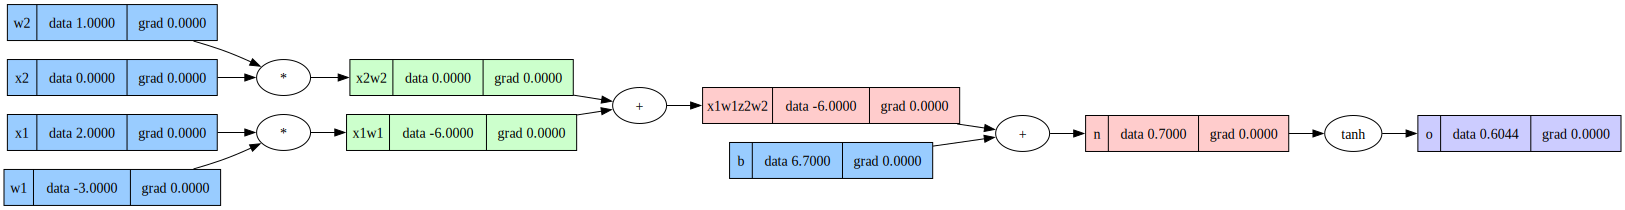

In [41]:
# o.data should be 0.6044
draw_dot(o)

##### **Exercise 4**: Implement the `backward()` function in each Value's operator: `__add__`, `__mul__`, `__tanh__` and assign it to `_backward`

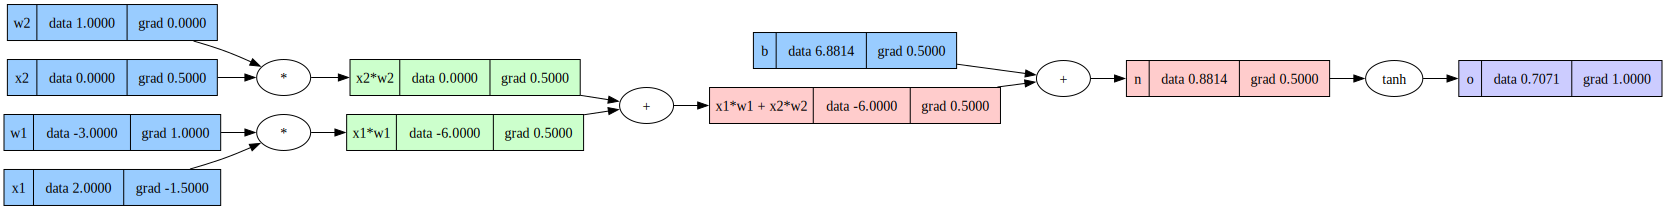

In [42]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
#e = (2*n).exp()
#o = (e - 1) / (e + 1)
o = n.tanh()
# ----
o.label = 'o'
o.backward()
draw_dot(o)

 # expected results:
 # o.data should be 0.7071
 # w1.grad = 1.0
 # w2.grad = 0.0
 # x1.grad = -1.5
 # x2.grad = 0.5

##### **Exercise 5**: why are we using self.grad += and not self.grad = in the backward() functions?  Answer as a comment in this cell. (Hint: create a Value "a" and then b = a + a. What happens when you do b.backward()?)

**Answer**: *We use `self.grad += x` instead of `self.grad = x` because we need to accumulate gradients rather than overwrite them.  
In the context of backpropagation, a single variable can contribute to multiple paths in the computation graph. If we were to simply assign `self.grad = x`, we would erase any previously computed gradients, losing valuable information from past operations.* 

*When we call `b.backward()`, `a` contributes to `b` twice. If we were to use `self.grad = x`, we would only keep the last computed gradient, discarding the contribution from the first occurrence. By using `self.grad += x`, we ensure that the gradients are correctly accumulated, allowing proper gradient flow through the entire computation graph.*

In [43]:
a = Value(5.0, label='a')
b = a + a 

b.grad = 1.0
b._backward() 

print(a.grad)

2.0


##### **Exercise 6**: replace the tanh() function by a combination of exp() and division.  Implement the __exp__ and __pow__ functions in Value. You should get the same results as before.


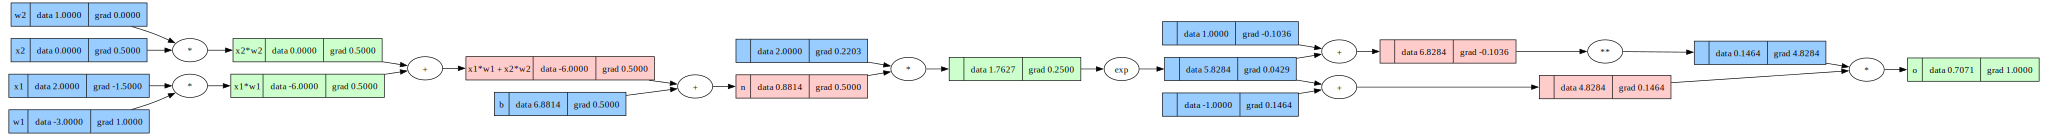

In [44]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
#o = ... (no tanh allowed)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [45]:
# Congratulations!  You "unlocked" the basic layer of pytorch.  Now you know what happens under the hood of the following code. Check that you get the same output as before for grad values.

import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())
# seems to match


0.7071066904050358
---
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


##### **Exercise 7**: Let's build an MLP based on the Value class.  Fill in the Neuron, Layer and MLP classes.

In [46]:
def flatten(xss):
    """simple function to flatten a list of list
    """
    return [x for xs in xss for x in xs]

class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum([wi * xi for wi, xi in zip(self.w, x)]) + self.b
    #act = self.w * x + b
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return flatten([n.parameters() for n in self.neurons])
  

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def _forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x  
  def __call__(self, x):
    if isinstance(x[0], list):
      out = [self._forward(el) for el in x]
    else:
      out = self._forward(x)

    return out
  
  def parameters(self):
    return flatten([layer.parameters() for layer in self.layers])

In [47]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.8780207350063222)

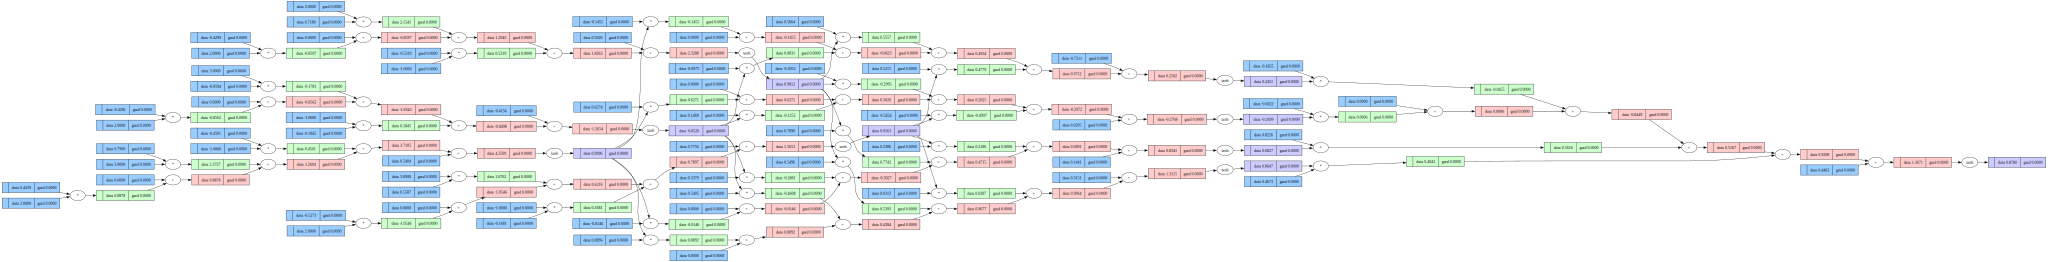

In [48]:
draw_dot(n(x))

In [49]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


##### **Exercise 8**: write a training loop

In [50]:
def loss_fcn(ypred, ys):
    return sum([(a-b)**2 for (a,b) in zip(ypred, ys)])

lr = 1e-1
for k in range(20):
    # forward pass (compute the loss)
    ypred = n(xs)
    loss =  loss_fcn(ypred, ys)# MSE between ypred and ground-truth
    loss.backward()
    # update
    for param in n.parameters():
        param.data -= lr * param.grad
    print(k, loss.data)
    loss.zerograd()

0 4.108939147887452
1 1.998466325816772
2 1.9046777344544934
3 2.28170187664569
4 0.11412647111898647
5 0.07646787703753932
6 0.06093085932130671
7 0.05124862056584997
8 0.04438935650519585
9 0.03919716013592843
10 0.03510080989350795
11 0.03177445210717283
12 0.02901444286967321
13 0.026685232717907677
14 0.024692329272874163
15 0.02296748335953724
16 0.02145999071833861
17 0.0201313027684253
18 0.01895154137577982
19 0.017897164674951803


In [51]:
_ = [print(y_pred.data, y) for y_pred, y in zip(n(xs), ys)]

0.9369887683890916 1.0
-0.9674568442609982 -1.0
-0.913397274610095 -1.0
0.9335180234393076 1.0


##### **Exercise 9**: why do you need to reset the grads to zero at every training step?  Answer as a comment in this cell.


**Answer**: *Gradients accumulate by default with each .backward() call. If we don't reset them to zero, they will keep adding up over
multiple steps, which will lead to incorrect updates. Therefore, we need to zero the gradients before each backward pass 
to ensure proper optimization.*

##### **Exercise 10 (*)**: try to approximate the n^2 function with a 2-layer MLP.  why is it so hard?


**Answer**: I see three reason that make it difficult to approximate the function \( f(n) = n^2 \) with a 2-layer MLP:

1. *Non-linearity*: A simple 2-layer MLP (i.e., one hidden layer) might struggle to capture the quadratic nature of \( n^2 \) (even with non-linear activation function)

2. *Shallow Network*: A single hidden layer with a small number of neurons may not have enough expressive power to approximate the complex curvature of \( n^2 \). While a deeper network can learn more intricate patterns, a shallow network has to approximate the function using fewer transformations, which might require an impractically large number of neurons.

3. *Poor generalization*: Neural networks, especially shallow ones, often interpolate well within the range of training data but struggle with extrapolation.

In [61]:
# Générer les données d'entraînement
inputs = np.linspace(-2, 2, 50)
targets = inputs**2

inputs = [[el] for el in inputs]
targets = [el for el in targets]

# Créer le modèle MLP
mlp_model = MLPRelu(1, [4, 4, 1])

# Taux d'apprentissage
learning_rate = 1e-1

# Boucle d'entraînement
for epoch in range(1000):
    # Passage avant (calcul de la perte)
    predictions = mlp_model(inputs)
    loss_value = loss_fcn(predictions, targets)  # MSE entre les prédictions et la vérité terrain
    loss_value.backward()

    # Mise à jour des paramètres
    for param in mlp_model.parameters():
        param.data -= learning_rate * param.grad
    
    # Affichage de la perte toutes les 50 itérations
    if epoch % 50 == 0:
        print(epoch, loss_value.data)
    
    # Réinitialiser les gradients
    loss_value.zerograd()

# Affichage des résultats
plt.figure(figsize=(8, 6))

# Affichage des prédictions du modèle
plt.plot([res.data for res in mlp_model(inputs)], label="Prédictions", color='blue', linestyle='-', linewidth=2)

# Affichage de la courbe cible
plt.plot(targets, label="Cible", color='red', linestyle='--', linewidth=2)

# Ajout des labels et du titre
plt.title("Approximation de la fonction $f(n) = n^2$ par un MLP", fontsize=14)
plt.xlabel("Entrées (n)", fontsize=12)
plt.ylabel("Sortie (f(n))", fontsize=12)

# Affichage de la légende
plt.legend()

# Affichage de la grille
plt.grid(True)

# Affichage du graphique
plt.show()

NameError: name 'MLPRelu' is not defined